Facial Keypoint Detection


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np 
import pandas as pd 
import os
import missingno as msno 

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
%matplotlib inline 

checker = 0
for dirname, _, filenames in os.walk('drive/My Drive/facial_keypoints_data/'):
    for filename in filenames:
        if (os.path.join(dirname, filename) is not None): checker += 1
if checker == 4: print('All files are available')

In [0]:
# test = pd.read_csv('drive/My Drive/facial_keypoints_data/test/test.csv')
# test.info()

# EDA

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')

In [0]:
#! TODO: check how variables behaves - quartiles, intervals
#  maybe there is a way to create challenger simply by putting coordinates as means/medians
training.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


How does y look like?

In [0]:
training.loc[:, training.columns != 'Image'].head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


How does X look like?

In [0]:
training['Image'].head(3)

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
Name: Image, dtype: object

### Missing values



Check how many NAs are in each column




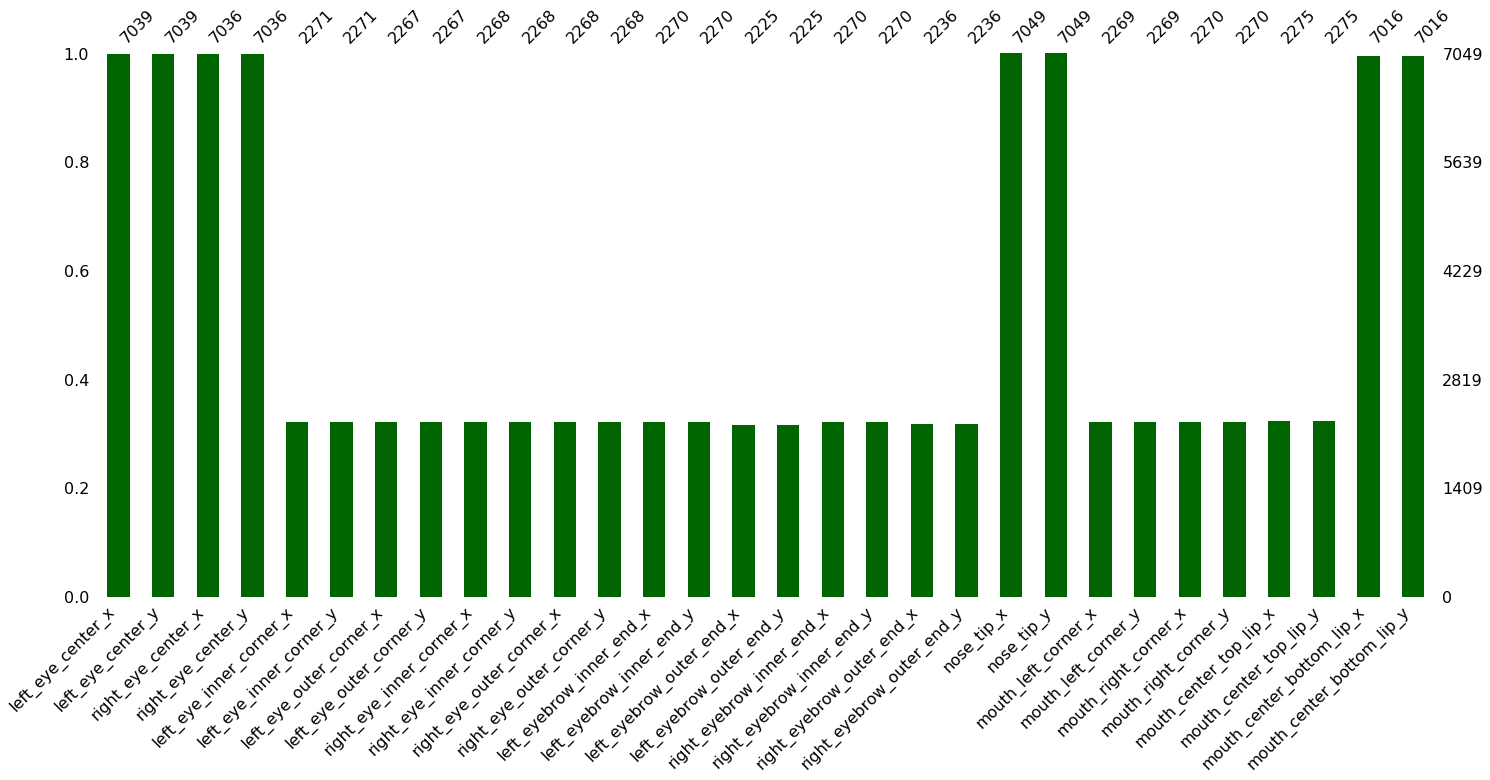

In [0]:
msno.bar(training[training.columns[:-1]], color='darkgreen') 

In [0]:
# check precisely how many NAs are in each colum
# training.isna().sum()

### Drop NAs



In [0]:
# drop NA rows
training = training.dropna()
#training.fillna(method = 'ffill',inplace = True)

In [0]:
training.shape, type(training)

((2140, 31), pandas.core.frame.DataFrame)

### Visualization


In [0]:
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [0]:
training['Image']

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
7044    [[71, 74, 85, 105, 116, 128, 139, 150, 170, 18...
7045    [[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ...
7046    [[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ...
7047    [[254, 254, 254, 254, 254, 238, 193, 145, 121,...
7048    [[53, 62, 67, 76, 86, 91, 97, 105, 105, 106, 1...
Name: Image, Length: 7049, dtype: object

In [0]:
def get_image_and_dots(df, index):
    image = plt.imshow(df['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'ro'))
        
    return image, l

def plot_faces(plot_dim = 6):
  fig = plt.figure(figsize=(12, 12))
  fig.subplots_adjust(
      left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

  for i in range(plot_dim*plot_dim):
      ax = fig.add_subplot(plot_dim, plot_dim, i + 1, xticks=[], yticks=[])
      get_image_and_dots(training, i)

  # plt.savefig('drive/My Drive/visualization.png', bbox_inches='tight')
  plt.show()

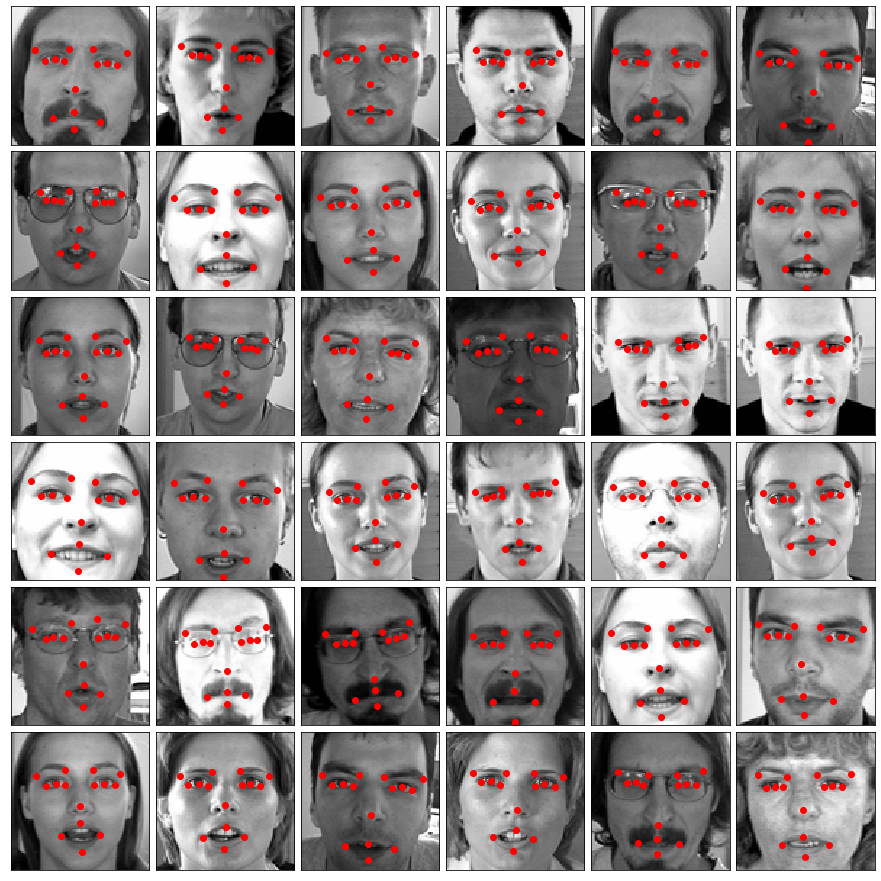

In [0]:
plot_faces(6)

Now we need to create X and Y matrixes. 

X's values are images (reshaped strings from datasource)

Y's are all features - 31 distinct features of human faces



In [0]:
X = np.asarray([training['Image']], dtype=np.uint8).reshape(training.shape[0],96,96,1)
y = training.drop(['Image'], axis=1)

In [0]:
print(f"X's shape: {X.shape}")
print(f"y's shape: {y.shape}")
print(f"X type: {type(X)}, Y type: {type(y)}")
yn = y.to_numpy()
print(f"yn type: {type(yn)}, yn shape: {yn.shape}")

X's shape: (2140, 96, 96, 1)
y's shape: (2140, 30)
X type: <class 'numpy.ndarray'>, Y type: <class 'pandas.core.frame.DataFrame'>
yn type: <class 'numpy.ndarray'>, yn shape: (2140, 30)


# Preprocessing



### Creating X and y

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training = training.dropna()

# scale pixel values to [0, 1]
X = np.vstack(training['Image'].values) / 255.
X = X.astype(np.float32)

y = training[training.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

### Train and test split

Now we need to create train and test sets for all models

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

# RMSE definition

In [3]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# **1st Model - Random Forest / XGBoost**

In [0]:
# random forest implementation

# **2nd Model - MLP**



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
model = Sequential([
  Dense(256, input_dim=X_train.shape[1], activation = 'relu'),
  Dropout(0.1),

  Dense(128, activation = 'relu'),
  Dropout(0.3),
  
  Dense(64, activation = 'relu'),
  Dense(30)
])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1950      
T

### MLP training

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model.compile(loss = root_mean_squared_error,
              optimizer = sgd)

hist_mlp = model.fit(X_train,
                     y_train,
                     epochs=500,
                     batch_size=128,
                     validation_split=0.1,
                     verbose=0)
print('Model trained')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Model trained


### Loss visualization

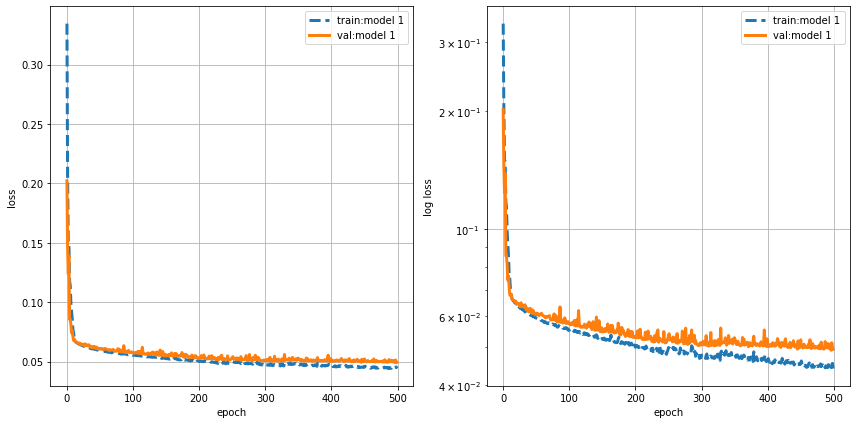

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")


plt.tight_layout()
# plt.savefig('drive/My Drive/MLP_loss.png', bbox_inches='tight')
plt.show()

In [0]:
loss_eval = model.evaluate(X_test, y_test, batch_size=128)
print('Test loss(RMSE):', loss_eval)
# print('Test accuracy:', acc)

321/321 [==============================] - 0s 68us/step
Test loss(RMSE): 0.04713146452359693


In [0]:
round(loss_eval * 48, 3)

2.262

#### TODO: compare test real with prediction on images

# **3rd Model - CNN**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

Preprocessing for CNN (reshaping from 1d vector)



In [0]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.04 or logs.get('loss') < 0.02):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [43]:
model = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),

  Conv2D(32, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Flatten(),
  Dense(512,activation='relu'),
  Dropout(0.1),
  Dense(30)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 48, 48, 64)       

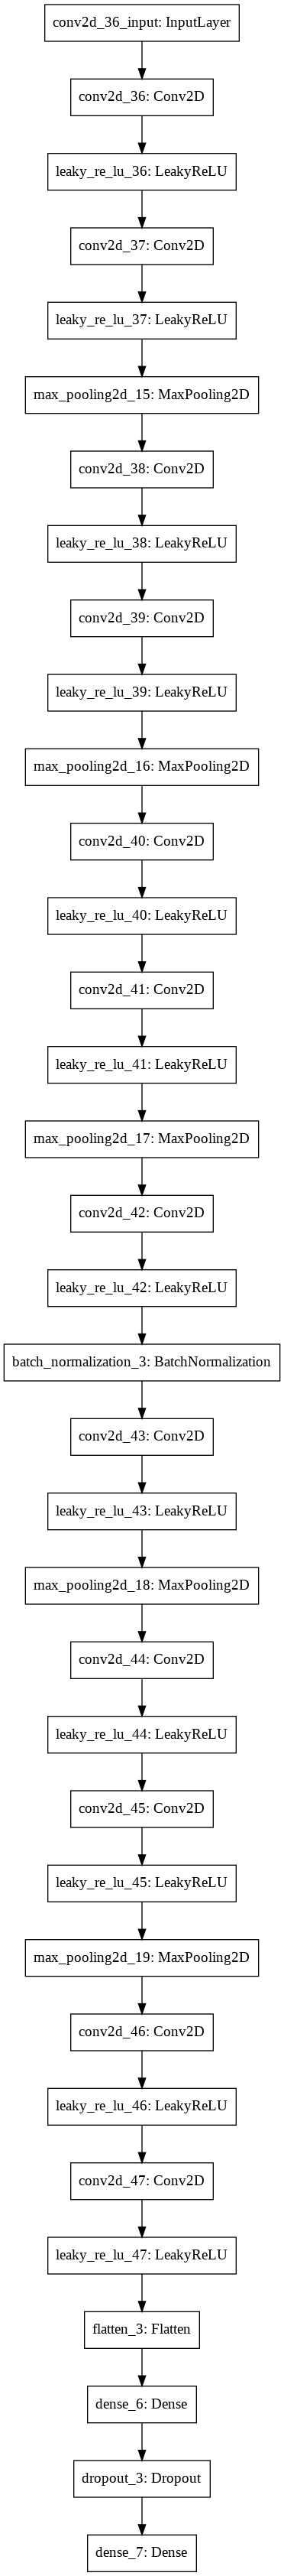

In [32]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='drive/My Drive/facial_keypoints_data/cnn_rmse_.png')

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [45]:
hist_cnn = model.fit(X_train,
                     y_train,
                     epochs=600,
                     batch_size=128,
                     validation_split=0.1,
                     verbose = 0,
                     callbacks=[callbacks]
                     )

Epoch 1
Loss :0.10438812399828078 -- Val Loss: 0.3235845048348982

Epoch 11
Loss :0.06844468489880962 -- Val Loss: 0.27875348860090904

Epoch 21
Loss :0.06031719290025 -- Val Loss: 0.2374678054353693

Epoch 31
Loss :0.05312118730032742 -- Val Loss: 0.16702380088659433

Epoch 41
Loss :0.04789473391300159 -- Val Loss: 0.09418938137017764

Epoch 51
Loss :0.043793335183772215 -- Val Loss: 0.056542443132007514

Epoch 61
Loss :0.038839785797463444 -- Val Loss: 0.04585092731720799

Epoch 71
Loss :0.03594574505644159 -- Val Loss: 0.04511216569405336

Epoch 81
Loss :0.033221923586302 -- Val Loss: 0.045099315694072745

Epoch 91
Loss :0.03205964739321206 -- Val Loss: 0.04532133894307273

Epoch 101
Loss :0.029396806810012516 -- Val Loss: 0.042999495475829305

Epoch 111
Loss :0.028390938775681038 -- Val Loss: 0.04292187446748817

Epoch 121
Loss :0.026610433509164855 -- Val Loss: 0.042722492959800656

Epoch 131
Loss :0.0250015768370999 -- Val Loss: 0.0427596254663153

Epoch 141
Loss :0.0235804603068

In [0]:
model.save('drive/My Drive/cnn_1st_rmse_1_78.h5')

### Loss visualization

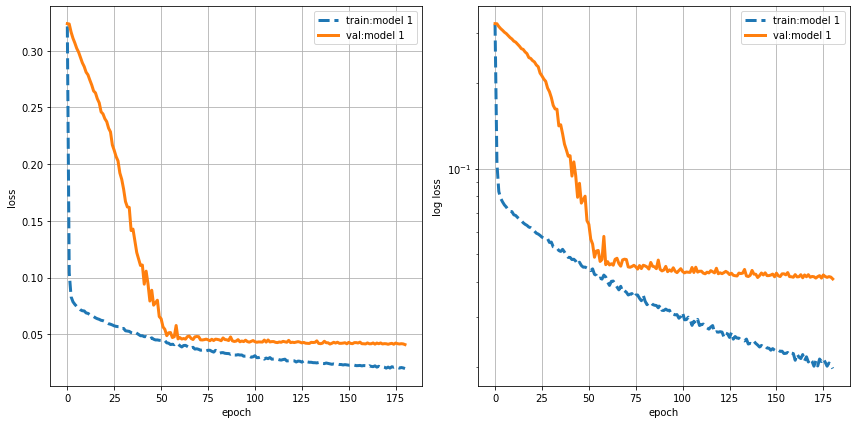

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_loss.png', bbox_inches='tight')
plt.show()

### Evaluation

In [47]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', round(score*48, 3))

Test RMSE: 0.03724048385321166
Rescaled RMSE: 1.788


In [0]:
y_eval = model.predict(X_test)

### Plotting predicted and real

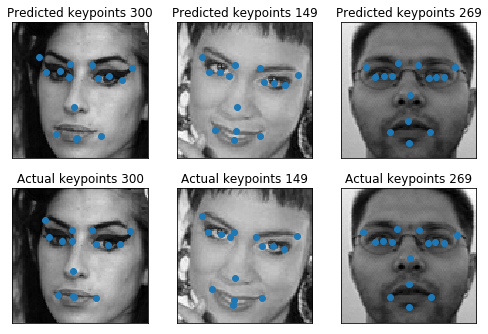

In [50]:
def plot_sample(X,y,axs):
    '''
    kaggle picture is 96 by 96
    y is rescaled to range between -1 and 1
    '''
    
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
picture_id = [300,149,269]

for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_eval[ipic],ax)
    ax.set_title("Predicted keypoints "+ str(ipic))
    count += 1


for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("Actual keypoints "+ str(ipic))
    count += 1

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_faces_test_eval.png', bbox_inches='tight')
plt.show()

In [0]:
model.save('cnn_rmse_2_03.h5')

# **4th Model - CNN with transfer learning**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

## First CNN (with 8 coordinates)

### Preprocessing for CNN with few features

In [52]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
# training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training.shape

(7049, 31)

Subset of all features (no NAs):


In [53]:
training_all_features = training.dropna()
training_all_features.shape

(2140, 31)

Subset with 8 features and images:

In [54]:
df_all = training.merge(training_all_features.drop_duplicates(), on=['Image'], 
                   how='left', indicator=True)
training_few_features = df_all[df_all['_merge'] == 'left_only'].iloc[:,0:31]
training_few_features = training_few_features.dropna(axis=1, thresh=len(training_few_features) - 34)
training_few_features.shape

(4908, 9)

Separating test set (for final model) from training_all_features

In [55]:
training_all_features = shuffle(training_all_features, random_state=666)
test_final = training_all_features.head(300)
training_all_features = training_all_features.tail(len(training_all_features) - 300)
training_all_features.shape

(1840, 31)

Combining training_few_features with training_all_features

In [56]:
print(training_few_features.shape)
print(training_all_features.shape)

(4908, 9)
(1840, 31)


In [0]:
training_few_features.columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

In [58]:
training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']].shape

(1840, 9)

In [0]:
training_cnn = pd.concat([training_few_features, training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']]])

In [60]:
training_cnn.shape

(6748, 9)

### Train/test split for CNN with few features

In [0]:
# training_cnn

In [0]:
training_cnn['Image'] = training_cnn['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_cnn = training_cnn.dropna()
# scale pixel values to [0, 1]
X = np.vstack(training_cnn['Image'].values) / 255.
X = X.astype(np.float32)

y = training_cnn[training_cnn.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [62]:
training_cnn.isna().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

In [64]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(5694, 96, 96, 1)
(1005, 96, 96, 1)


### CNN with few features training

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.045 or logs.get('loss') < 0.035):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [96]:
model = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),

  Conv2D(32, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  # Conv2D(256, (3,3),padding='same',use_bias=False),
  # LeakyReLU(alpha = 0.1),

  # Conv2D(256, (3,3),padding='same',use_bias=False),
  # LeakyReLU(alpha = 0.1),
  # MaxPool2D(pool_size=(2, 2)),

  # Conv2D(512, (3,3), padding='same', use_bias=False),
  # LeakyReLU(alpha = 0.1),

  # Conv2D(512, (3,3), padding='same', use_bias=False),
  # LeakyReLU(alpha = 0.1),

  Flatten(),
  Dense(256,activation='relu'),
  Dropout(0.1),
  Dense(8)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 48, 48, 64)       

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [69]:
hist_cnn_ff = model.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 0,
                        callbacks=[callbacks]
                     )

Epoch 1
Loss :0.07924897194629903 -- Val Loss: 0.18856694144115113

Epoch 11
Loss :0.05765184979946887 -- Val Loss: 0.09446533241292887

Epoch 21
Loss :0.048722233722141996 -- Val Loss: 0.056882213291368985

Epoch 31
Loss :0.04307011151097418 -- Val Loss: 0.05207586148590372

Epoch 41
Loss :0.0384888825974457 -- Val Loss: 0.05357533025375584


Reached target loss so cancelling training!


#### Loss visualization

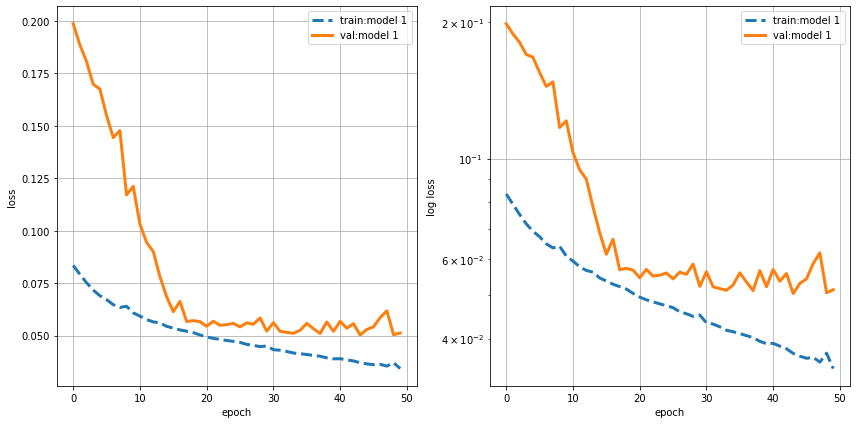

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
plt.show()

#### Evaluation

In [71]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', score*48)

Test RMSE: 0.05210991295341828
Rescaled RMSE: 2.501275821764078


#### Saving weights

In [0]:
# from keras.models import model_from_json

# def save_model(model,name):
#     json_string = model.to_json()
#     open(name+'_architecture.json', 'w').write(json_string)
#     model.save_weights(name+'_weights.h5')
    
# def load_model(name):
#     model = model_from_json(open(name+'_architecture.json').read())
#     model.load_weights(name + '_weights.h5')
#     return(model)

# save_model(model,"model1")
# model = load_model("model1")

In [0]:
model.save('drive/My Drive/cnn_ff_rmse_2_43.h5')

In [0]:
model.load_weights(name + 'cnn_ff_rmse_2_43.h5')

#### Preparing for transfer learning

In [72]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 48, 48, 64)       

In [88]:
last_layer = model.get_layer('leaky_re_lu_67')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

for layer in model.layers:
  layer.trainable = False

last layer output shape:  (None, 12, 12, 128)


In [0]:
# x =  Conv2D(128, (3,3), padding='same', activation='relu')(last_output)
# x =  MaxPool2D(2,2)(x)
# x =  Dropout(0.1)(x)

# x =  Conv2D(128, (3,3), padding='same', activation='relu')(x)
# x =  MaxPool2D(2,2)(x)
# x =  Dropout(0.2)(x)

# x =  Conv2D(128, (3,3), padding='same', use_bias=False)(x)
# x =  LeakyReLU(alpha = 0.1)(x)
# x =  MaxPool2D(pool_size=(2, 2))(x)

# x =  Conv2D(128, (3,3), padding='same', use_bias=False)(x)
# x =  LeakyReLU(alpha = 0.1)(x)
# # x =  BatchNormalization()(x)
# x =  MaxPool2D(pool_size=(2, 2))(x)

x =  Flatten()(x)
x =  Dense(512, activation='relu')(x)
x =  Dropout(0.2)(x)                  

x =  Dense(30, activation='sigmoid')(x)           


In [0]:
model_tf = Model( model.input, x) 

# model_tf.compile(optimizer = RMSprop(lr=0.0001), 
#               loss = 'binary_crossentropy', 
#               metrics = ['acc'])

In [91]:
model_tf.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60_input (InputLayer) [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 48, 48, 64)        1843

#### Preprocessing for all features

In [0]:
test_final['Image'] = test_final['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_all_features['Image'] = training_all_features['Image'].apply(lambda x: np.fromstring(x, sep=' '))

# TEST SET
# test_final = training_all_features.head(300)
X_test = np.vstack(test_final['Image'].values) / 255.
X_test = X_test.astype(np.float32)

y_test = test_final[test_final.columns[:-1]].values
y_test = (y_test - 48) / 48  # scale target coordinates to [-1, 1]
y_test = y_test.astype(np.float32)

# TRAIN SET
# training_all_features = training_all_features.tail(len(training_all_features) - 300)
X_train = np.vstack(training_all_features['Image'].values) / 255.
X_train = X_train.astype(np.float32)

y_train = training_all_features[training_all_features.columns[:-1]].values
y_train = (y_train - 48) / 48  # scale target coordinates to [-1, 1]
y_train = y_train.astype(np.float32)

In [93]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(0, 96, 96, 1)
(0, 96, 96, 1)


In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_tf.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [95]:
hist_cnn_af = model_tf.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 1,
                        callbacks=[callbacks]
                     )

ValueError: ignored

In [87]:
score = model_tf.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', score*48)

Test RMSE: 0.2646626448631287
Rescaled RMSE: 12.703806953430178
